In [1]:
!git clone https://github.com/Z-Zheng/pytorch-change-models.git
!pip install ever-beta

fatal: destination path 'pytorch-change-models' already exists and is not an empty directory.


In [2]:
%cd pytorch-change-models

/content/pytorch-change-models


In [3]:
from torchange.models.changen2 import changestar_1x256

model = changestar_1x256(backbone_type="vitb", modeling_type="s1c1", changen2_pretrained="s0")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please n

In [4]:
print(model)

ChangeStar1xd(
  (encoder): SAMEncoderFarSeg(
    (vit): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
          (drop_path): Identity()
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Single Data Test

In [6]:
import torch
from PIL import Image
import numpy as np

t1_path = "/content/drive/MyDrive/Datasets/test_data/t1_rgb/0016.png"
t2_path = "/content/drive/MyDrive/Datasets/test_data/t2_rgb/0016.png"

# Load the images
t1_image = Image.open(t1_path)
t2_image = Image.open(t2_path)


# Convert the images to numpy arrays
t1_array = np.array(t1_image).astype(np.float32) / 255.0
t2_array = np.array(t2_image).astype(np.float32) / 255.0

# Reorder the dimensions to (channels, height, width)
t1_array = torch.tensor(np.transpose(t1_array, (2, 0, 1)))  # (height, width, channels) -> (channels, height, width)
t2_array = torch.tensor(np.transpose(t2_array, (2, 0, 1)))  # (height, width, channels) -> (channels, height, width)

# Verify the shape
print(f"t1_array shape: {t1_array.shape}")
print(f"t2_array shape: {t2_array.shape}")

t1_array shape: torch.Size([3, 512, 512])
t2_array shape: torch.Size([3, 512, 512])


In [7]:
bi_images = torch.cat([t1_array.unsqueeze(0), t2_array.unsqueeze(0)], dim=1)  # [b, tc, h, w]
bi_images.shape

torch.Size([1, 6, 512, 512])

In [8]:
bi_images = bi_images.float()
bi_images

tensor([[[[0.1098, 0.0941, 0.0980,  ..., 0.0745, 0.0824, 0.0667],
          [0.1020, 0.0980, 0.0980,  ..., 0.0863, 0.0706, 0.0667],
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.2039, 0.1412, 0.0824,  ..., 0.1490, 0.1255, 0.0824],
          [0.1647, 0.1216, 0.0706,  ..., 0.1451, 0.1216, 0.0667],
          [0.1373, 0.0902, 0.0784,  ..., 0.1059, 0.0941, 0.0549]],

         [[0.1098, 0.0941, 0.0863,  ..., 0.0745, 0.0863, 0.0627],
          [0.0784, 0.0863, 0.0784,  ..., 0.0902, 0.0745, 0.0706],
          [0.0784, 0.0784, 0.0784,  ..., 0.0824, 0.0784, 0.0784],
          ...,
          [0.1922, 0.1647, 0.1451,  ..., 0.1529, 0.1294, 0.0863],
          [0.1765, 0.1608, 0.1412,  ..., 0.1137, 0.1098, 0.0667],
          [0.1686, 0.1529, 0.1490,  ..., 0.0824, 0.0784, 0.0549]],

         [[0.0667, 0.0549, 0.0627,  ..., 0.0471, 0.0549, 0.0392],
          [0.0471, 0.0510, 0.0471,  ..., 0.0549, 0.0510, 0.0392],
          [0.0431, 0.0431, 0.0510,  ..., 0

In [9]:
model.training = False
predictions = model(bi_images)
change_logit = predictions['change_prediction'].to(torch.float32)  # [b, 1, h, w]

In [10]:
change_logit

tensor([[[[ -4.3287,  -4.0369,  -3.7450,  ..., -10.0186,  -9.9824,  -9.9463],
          [ -4.7808,  -4.6063,  -4.4318,  ..., -10.1676, -10.0980, -10.0285],
          [ -5.2329,  -5.1758,  -5.1187,  ..., -10.3165, -10.2136, -10.1106],
          ...,
          [ -0.3197,  -0.6921,  -1.0645,  ..., -12.4711, -13.0433, -13.6155],
          [  0.5101,  -0.0974,  -0.7048,  ..., -12.0322, -12.7063, -13.3805],
          [  1.3399,   0.4974,  -0.3452,  ..., -11.5932, -12.3694, -13.1455]]]],
       grad_fn=<UpsampleBilinear2DBackward0>)

In [11]:
change_logit.shape

torch.Size([1, 1, 512, 512])

In [12]:
change_prob = torch.sigmoid(change_logit)

In [13]:
print(change_prob)

tensor([[[[1.3013e-02, 1.7347e-02, 2.3090e-02,  ..., 4.4562e-05,
           4.6203e-05, 4.7904e-05],
          [8.3192e-03, 9.8895e-03, 1.1753e-02,  ..., 3.8395e-05,
           4.1160e-05, 4.4124e-05],
          [5.3094e-03, 5.6198e-03, 5.9483e-03,  ..., 3.3081e-05,
           3.6668e-05, 4.0643e-05],
          ...,
          [4.2074e-01, 3.3356e-01, 2.5645e-01,  ..., 3.8359e-06,
           2.1645e-06, 1.2214e-06],
          [6.2483e-01, 4.7568e-01, 3.3074e-01,  ..., 5.9497e-06,
           3.0318e-06, 1.5450e-06],
          [7.9248e-01, 6.2184e-01, 4.1455e-01,  ..., 9.2281e-06,
           4.2466e-06, 1.9542e-06]]]], grad_fn=<SigmoidBackward0>)


In [14]:
# Assuming change_prob is a 4D tensor with shape [batch_size, 1, height, width]
# Apply a threshold to get the binary mask (threshold is commonly set to 0.5)
binary_mask = (change_prob >= 0.5).float()  # Thresholding the probabilities at 0.5

# You can convert to uint8 for display purposes (values will be 0 or 1)
binary_mask_uint8 = (binary_mask * 255).to(torch.uint8)  # Convert to 0 or 255 for image display

# Since we have a batch dimension, we can take the first image (batch[0]) and the first channel (change prediction)
binary_mask_image = binary_mask_uint8[0, 0, :, :].cpu().numpy()  # Convert to NumPy array for plotting


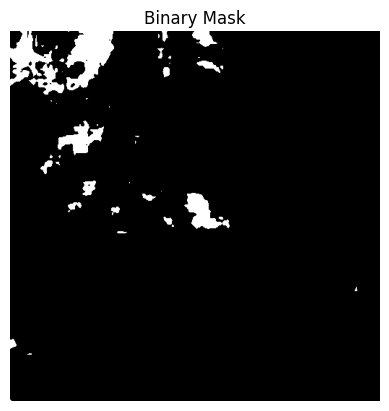

In [15]:
import matplotlib.pyplot as plt

# Display the binary mask
plt.imshow(binary_mask_image, cmap='gray')
plt.title("Binary Mask")
plt.axis("off")  # Hide the axes for cleaner display
plt.show()

## Batch Evaluation

In [16]:
import os
import json
import imageio.v3 as imageio
from sklearn.metrics import (
    jaccard_score, f1_score, precision_score, recall_score, accuracy_score, cohen_kappa_score
)

In [17]:
# Paths and model setup
base_path = '/content/drive/MyDrive/Datasets/test_data/'
t1_path = os.path.join(base_path, 't1_rgb')
t2_path = os.path.join(base_path, 't2_rgb')
gt_path = os.path.join(base_path, 'gt_grayscale')
test_out_path = "/content/drive/MyDrive/Datasets/test_data/"
metrics_out_file = os.path.join(test_out_path, "metrics_results.json")

In [18]:
# Evaluation metrics function
def evaluate_metrics(predicted, ground_truth):
    # Flatten both arrays
    predicted = predicted.flatten()
    ground_truth = ground_truth.flatten()

    # Normalize to binary labels if necessary (0 and 1)
    if 255 in predicted or 255 in ground_truth:
        predicted = (predicted / 255).astype(int)
        ground_truth = (ground_truth / 255).astype(int)

    # Calculate metrics
    metrics = {
        "Jaccard Index (IoU)": jaccard_score(ground_truth, predicted, average="binary"),
        "F1 Score": f1_score(ground_truth, predicted, average="binary"),
        "Precision": precision_score(ground_truth, predicted, average="binary"),
        "Recall": recall_score(ground_truth, predicted, average="binary"),
        "Accuracy": accuracy_score(ground_truth, predicted),
        "Cohen's Kappa Score": cohen_kappa_score(ground_truth, predicted)
    }
    return metrics

In [19]:
# Initialize variables to track the sum of each metric
metric_sums = {
    "Jaccard Index (IoU)": 0,
    "F1 Score": 0,
    "Precision": 0,
    "Recall": 0,
    "Accuracy": 0,
    "Cohen's Kappa Score": 0
}

# Total number of images processed
num_images = 0
all_metrics = {}

for filename in os.listdir(t1_path):
    t1_image_path = os.path.join(t1_path, filename)
    t2_image_path = os.path.join(t2_path, filename)
    gt_image_path = os.path.join(gt_path, filename)

    # Check if corresponding files exist
    if not os.path.isfile(t2_image_path) or not os.path.isfile(gt_image_path):
        print(f"Missing corresponding file for {filename}")
        continue

   # Load the images
    t1_image = Image.open(t1_image_path)
    t2_image = Image.open(t2_image_path)
    gt_image = Image.open(gt_image_path)


    # Convert the images to numpy arrays
    t1_array = np.array(t1_image).astype(np.float32)
    t2_array = np.array(t2_image).astype(np.float32)
    gt_image = np.array(gt_image)

    # Reorder the dimensions to (channels, height, width)
    t1_array = torch.tensor(np.transpose(t1_array, (2, 0, 1)))  # (height, width, channels) -> (channels, height, width)
    t2_array = torch.tensor(np.transpose(t2_array, (2, 0, 1)))  # (height, width, channels) -> (channels, height, width)

    bi_images = torch.cat([t1_array.unsqueeze(0), t2_array.unsqueeze(0)], dim=1)
    bi_images = bi_images.float()

    # Model prediction
    predictions = model(bi_images)
    change_logit = predictions['change_prediction'].to(torch.float32)  # [b, 1, h, w]]
    change_prob = torch.sigmoid(change_logit)

    # Assuming change_prob is a 4D tensor with shape [batch_size, 1, height, width]
    # Apply a threshold to get the binary mask (threshold is commonly set to 0.5)
    binary_mask = (change_prob >= 0.5).float()  # Thresholding the probabilities at 0.5

    # You can convert to uint8 for display purposes (values will be 0 or 1)
    binary_mask_uint8 = (binary_mask * 255).to(torch.uint8)  # Convert to 0 or 255 for image display

    # Since we have a batch dimension, we can take the first image (batch[0]) and the first channel (change prediction)
    binary_mask_image = binary_mask_uint8[0, 0, :, :].cpu().numpy()  # Convert to NumPy array for plotting


    # Save the output change map for visualization
    imageio.imwrite(os.path.join(test_out_path, f"{filename}_change.png"), binary_mask_image)

    # Evaluate metrics
    metrics = evaluate_metrics(binary_mask_image, gt_image)
    print(f"Metrics for {filename}: {metrics}")

    # Save metrics for this image
    all_metrics[filename] = metrics

    # Add metrics to the sums
    for metric_name in metrics:
        metric_sums[metric_name] += metrics[metric_name]

    num_images += 1

# Calculate the average of each metric
if num_images > 0:
    avg_metrics = {metric: metric_sums[metric] / num_images for metric in metric_sums}
    print("\nAverage Metrics:")
    for metric, avg_value in avg_metrics.items():
        print(f"{metric}: {avg_value:.4f}")

    # Save metrics to JSON
    all_metrics["Average"] = avg_metrics
    with open(metrics_out_file, "w") as f:
        json.dump(all_metrics, f, indent=4)
    print(f"Metrics saved to {metrics_out_file}")
else:
    print("No images processed.")

Metrics for 0139_1.png: {'Jaccard Index (IoU)': 0.009292351679771264, 'F1 Score': 0.018413597733711047, 'Precision': 0.027339642481598318, 'Recall': 0.013881473571809931, 'Accuracy': 0.9894256591796875, "Cohen's Kappa Score": 0.013667166798639108}
Metrics for 0049.png: {'Jaccard Index (IoU)': 0.5435381871250202, 'F1 Score': 0.7042756592079, 'Precision': 0.765821338816541, 'Recall': 0.6518864255153637, 'Accuracy': 0.9892616271972656, "Cohen's Kappa Score": 0.6988431545779548}
Metrics for 0107.png: {'Jaccard Index (IoU)': 0.18162083936324167, 'F1 Score': 0.30740967544396813, 'Precision': 0.814935064935065, 'Recall': 0.18943396226415093, 'Accuracy': 0.9956855773925781, "Cohen's Kappa Score": 0.30608662701639056}
Metrics for 0016.png: {'Jaccard Index (IoU)': 0.0051963746223564955, 'F1 Score': 0.01033902380379899, 'Precision': 0.0061419797171832595, 'Recall': 0.032649962034927864, 'Accuracy': 0.968597412109375, "Cohen's Kappa Score": 0.0018980625076517876}
Metrics for 0139.png: {'Jaccard In